<a href="https://colab.research.google.com/github/hayatrajani/reinforcement-learning/blob/main/Cliff_Walking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required Modules

In [ ]:
import numpy as np
from operator import add, sub
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Circle
from tqdm import tqdm

%matplotlib inline
np.set_printoptions(linewidth=np.inf)

# Design the Grid World

![cliff_gridworld](https://drive.google.com/uc?id=1P_y0KPMxoFkvww5v5BZpIE8HsmMdB4u3)

The agent starts in the cell marked $S$.

When it reaches the cell marked $G$, it will receive a reward of $100$ and the episode ends.

If it enters the region marked "The Cliff", it will incur a reward of $-100$ and will be sent back to the start state.

If it tries to leave the grid, it will incur a reward of $-25$ and remain in the same state.

Every other step will be rewarded with $-1$.

The agent has eight (non-deterministic) actions:

* It can move to an adjacent cell according to eight-neighborhood.
* With probability 0.8, the desired action is carried out. With probability 0.1, the agent deviates from the desired direction by one cell to the left or to the right (axis-parallel moves become diagonal moves and vice versa).

The agent's initial policy is to move right with probability 0.5

In [ ]:
gridSize = (4,12)

startCell = (3,0)
goalCell = (3,11)

cliff = [(3, i) for i in range(1,11)]

goalReward = 100
cliffReward = -100
offGridReward = -25

rewards = np.zeros(gridSize)-1
for cell in cliff:
    rewards[cell] = cliffReward
rewards[goalCell] = goalReward


# possible actions: NW, N, NE, E, SE, S, SW, W
actions = ((-1,-1), (-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1))
nActions = len(actions)
actionProb = np.ones(nActions)*0.5/(nActions-1)
actionProb[3] = 0.5

initPolicy = lambda: np.random.choice(range(nActions), p=actionProb)


def step(state, actionID, deterministic=True):
    action = actions[actionID]
    # desired action is performed with probability 0.8
    # else action deviates to the left or right
    if not deterministic:
        rand = np.random.random()
        if rand > 0.8:
            # action deviates left
            if rand > 0.9:
                thetaDev = -np.pi/4
            # action deviates right
            else:
                thetaDev = np.pi/4
            rotMat = np.array([[np.cos(thetaDev),-np.sin(thetaDev)],
                               [np.sin(thetaDev),np.cos(thetaDev)]])
            # deviated action
            action = np.round(rotMat @ action).astype(int)
    # determine the new state, reward and check for terminal state
    nextState = tuple(map(add,state,action))
    done = False
    if 0 <= nextState[0] < gridSize[0] and 0 <= nextState[1] < gridSize[1]:
        reward = rewards[nextState]
        # send the agent back to the start cell if it moves onto the cliff
        if reward == cliffReward:
            nextState = startCell
        # end episode if terminal state
        elif reward == goalReward:
            done = True
    # agent remains in the same state if it tries to leave the grid
    else:
        reward = offGridReward
        nextState = state
    return (nextState, reward, done)


# TD(0) Policy Evaluation
def policyEvaluation(policy, V=np.zeros(gridSize), gamma=0.9, alpha=0.2, decay=True,
                     episodes=10000, deterministic=True, stats=False):
    if stats:
        nEpisode = np.zeros(episodes, dtype=int)
        returnPerEpisode = np.zeros(episodes)
    if decay:
        nVisit = np.zeros(gridSize, dtype=int)
    # repeat for each episode
    for episode in tqdm(range(episodes)):
        # starting from an initial state
        state = startCell
        # repeat for each step of the episode
        while True:
            # get an action for the current state
            actionID = policy()
            # take action and observe next state and reward
            state_, reward, done = step(state, actionID)
            if decay:
                alpha = 1/(nVisit[state]+1)
            # update state value
            V[state] += alpha*(reward + gamma*V[state_] - V[state])
            # move on to the next state
            state = state_
            if stats:
                nEpisode[episode] += 1
                returnPerEpisode[episode] += reward
            if decay:
                nVisit[state] += 1
            # until terminal state reached
            if done:
                break
    return V if not stats else V, (nEpisode, returnPerEpisode)


def epsGreedy(Qstate, epsilon=0.1):
    return np.random.choice(range(nActions)) if(np.random.random()<epsilon) else np.argmax(Qstate)

def softMax(Qstate, tau=42):
    actionProb = np.exp(Qstate/tau)
    actionProb /= np.sum(actionProb)
    return np.random.choice(range(nActions), p=actionProb)
    

def Sarsa(Q=np.zeros((*gridSize,nActions)), epsilon=0.1, tau=42, gamma=0.9, alpha=0.2,
          decay=True, episodes=10000, softmax=False, deterministic=True, stats=False):
    if stats:
        nEpisode = np.zeros(episodes, dtype=int)
        returnPerEpisode = np.zeros(episodes)
    if decay:
        nQVisit = np.zeros((*gridSize,nActions), dtype=int)
    # repeat for each episode
    for episode in tqdm(range(episodes)):
        # starting from an initial state
        state = startCell
        # get an action for the initial state using a policy derived from Q
        actionID = softMax(Q[state],tau) if softmax else epsGreedy(Q[state],epsilon)
        # repeat for each step of the episode
        while True:
            # take action and observe next state and reward
            state_, reward, done = step(state, actionID, deterministic)
            # get an action for the new state using a policy derived from Q
            actionID_ = softMax(Q[state],tau) if softmax else epsGreedy(Q[state],epsilon)
            if decay:
                nQVisit[state][actionID] += 1
                alpha = 1/nQVisit[state][actionID]
            # update action value
            Q[state][actionID] += alpha*(reward + gamma*Q[state_][actionID_] - Q[state][actionID])
            # move on to the next state-action pair
            state = state_
            actionID = actionID_
            if stats:
                nEpisode[episode] += 1
                returnPerEpisode[episode] += reward
            # until terminal state reached
            if done:
                break
    return Q if not stats else Q, (nEpisode, returnPerEpisode)


def QLearn(Q=np.zeros((*gridSize,nActions)), epsilon=0.1, tau=42, gamma=0.9, alpha=0.2,
           decay=True, episodes=10000, softmax=False, deterministic=True, stats=False):
    if stats:
        nEpisode = np.zeros(episodes, dtype=int)
        returnPerEpisode = np.zeros(episodes)
    if decay:
        nQVisit = np.zeros((*gridSize,nActions), dtype=int)
    # repeat for each episode
    for episode in tqdm(range(episodes)):
        # starting from an initial state
        state = startCell
        # repeat for each step of the episode
        while True:
            # get an action form the current state using a policy derived from Q
            actionID = softMax(Q[state],tau) if softmax else epsGreedy(Q[state],epsilon)
            # take action and observe next state and reward
            state_, reward, done = step(state, actionID, deterministic)
            if decay:
                nQVisit[state][actionID] += 1
                alpha = 1/nQVisit[state][actionID]
            # update action value
            Q[state][actionID] += alpha*(reward + gamma*np.max(Q[state_]) - Q[state][actionID])
            # move on to the next state
            state = state_
            if stats:
                nEpisode[episode] += 1
                returnPerEpisode[episode] += reward
            # until terminal state reached
            if done:
                break
    return Q if not stats else Q, (nEpisode, returnPerEpisode)


def DoubleQLearn(Q1=np.zeros((*gridSize,nActions)), Q2=np.zeros((*gridSize,nActions)),
                 epsilon=0.1, tau=42, gamma=0.9, alpha=0.2, decay=True,
                 episodes=10000, softmax=False, deterministic=True, stats=False):
    if stats:
        nEpisode = np.zeros(episodes, dtype=int)
        returnPerEpisode = np.zeros(episodes)
    if decay:
        nQVisit = np.zeros((*gridSize,nActions), dtype=int)
    # repeat for each episode
    for episode in tqdm(range(episodes)):
        # starting from an initial state
        state = startCell
        # repeat for each step of the episode
        while True:
            # get an action for the initial state using a policy derived from Q
            actionID = \
                softMax(Q1[state]+Q2[state],tau) if softmax else epsGreedy(Q1[state]+Q2[state],epsilon)
            # take action and observe next state and reward
            state_, reward, done = step(state, actionID, deterministic)
            if decay:
                nQVisit[state][actionID] += 1
                alpha = 1/nQVisit[state][actionID]
            # update action value
            if np.random.random() <= 0.5:
                Q1[state][actionID] += \
                    alpha*(reward + gamma*Q2[state_][np.argmax(Q1[state_])] - Q1[state][actionID])
            else:
                Q2[state][actionID] += \
                    alpha*(reward + gamma*Q1[state_][np.argmax(Q2[state_])] - Q2[state][actionID])
            # move on to the next state
            state = state_
            if stats:
                nEpisode[episode] += 1
                returnPerEpisode[episode] += reward
            # until terminal state reached
            if done:
                break
    return (Q1, Q2) if not stats else (Q1, Q2, (nEpisode, returnPerEpisode))


def plotPolicy(policy, deterministic=True):
    fig, ax = plt.subplots(1,1,figsize=(gridSize[1],gridSize[0]))
    ax.axis([0,gridSize[1],0,gridSize[0]])
    ax.set_xticks(range(gridSize[1]))
    ax.set_yticks(range(gridSize[0]))
    ax.grid(True, color='k', linewidth=1.5)
    ax.set_aspect(1)
    ax.invert_yaxis()
    ax.set_yticklabels([])
    ax.yaxis.set_ticks_position('none')
    ax.set_xticklabels([])
    ax.xaxis.set_ticks_position('none')
    ax.add_patch(Rectangle((startCell[1],startCell[0]),1,1,color='dodgerblue'))
    ax.add_patch(Rectangle((goalCell[1],goalCell[0]),1,1,color='springgreen'))
    for cell in cliff:
        ax.add_patch(Rectangle((cell[1],cell[0]),1,1,color='orangered'))
    state = startCell
    states = [state]
    while True:
        actionID = np.argmax(policy[state])
        nextState, _, done = step(state, actionID, deterministic)
        if nextState==state or nextState==startCell:
            continue
        states.append(nextState)
        state = nextState
        if done:
            break
    states = [(x+0.5,y+0.5) for y,x in states]
    ax.add_patch(Circle(states[0], radius=0.1, fill=True, color='darkviolet'))
    ax.add_patch(Polygon(states[:-1], closed=None, fill=None, edgecolor='darkviolet', linewidth=2))
    ax.arrow(states[-2][0],states[-2][1], states[-1][0]-states[-2][0],states[-1][1]-states[-2][1],
             head_width=0.3, head_length=0.15, length_includes_head=True,
             fill=True, color='darkviolet', linewidth=2)
    plt.show()


def plotStateValues(V):
    V = V.copy()
    V = np.round(V,2)
    fig, ax = plt.subplots(1,1,figsize=(gridSize[1],gridSize[0]))
    ax.set_xticks(range(gridSize[1]))
    ax.set_xticks(np.arange(-.5, gridSize[1], 1), minor=True);
    ax.set_xticklabels(range(1, gridSize[1]+1))
    ax.set_yticks(range(gridSize[0]))
    ax.set_yticks(np.arange(-.5, gridSize[0], 1), minor=True);
    ax.set_yticklabels(range(1, gridSize[0]+1))
    ax.grid(which='minor', color='k', linewidth=2)
    ax.invert_yaxis()
    ax.set_title('State Values for each Cell', fontsize=18)
    im = ax.imshow(V, cmap='hot')
    cbar = fig.colorbar(im, orientation='horizontal', pad=0.1)
    plt.show()


def displayStats(stats):
    nEpisode, returnPerEpisode = stats
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(211)
    ax.plot(range(100, len(returnPerEpisode)+1,100), 
            [r for i,r in enumerate(returnPerEpisode) if (i+1)%100==0])
    ax.set_xlabel('#Episode',fontsize=16)
    ax.set_ylabel('Return',fontsize=16)
    ax.set_title('Return per 100 Episodes',fontsize=18)
    ax = fig.add_subplot(212)
    ax.plot(range(10, len(nEpisode)+1,10), 
            [r for i,r in enumerate(nEpisode) if (i+1)%10==0])
    ax.set_xlabel('#Episode',fontsize=16)
    ax.set_ylabel('Length',fontsize=16)
    ax.set_title('Episode Lengths (per 100 episodes)',fontsize=18)
    plt.tight_layout()
    plt.show()

# Task 1

Randomly generate 10000 episodes according to the initial policy.

Compute the state value V(s) for each visited state using TD(0) Policy Evaluation.

100%|██████████| 10000/10000 [02:51<00:00, 58.37it/s]


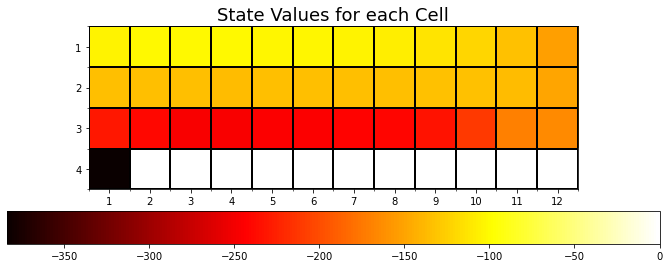



State Values for initial policy:

[[-103.49 -101.78 -101.68 -101.88 -102.12 -102.92 -104.65 -107.62 -112.47 -120.15 -132.97 -152.53]
 [-133.75 -134.34 -134.83 -134.95 -134.25 -134.62 -134.46 -134.32 -132.94 -132.07 -136.34 -149.8 ]
 [-230.14 -238.91 -246.37 -245.91 -244.84 -244.4  -241.33 -239.86 -232.81 -210.98 -169.84 -164.06]
 [-383.6     0.      0.      0.      0.      0.      0.      0.      0.      0.      0.      0.  ]] 



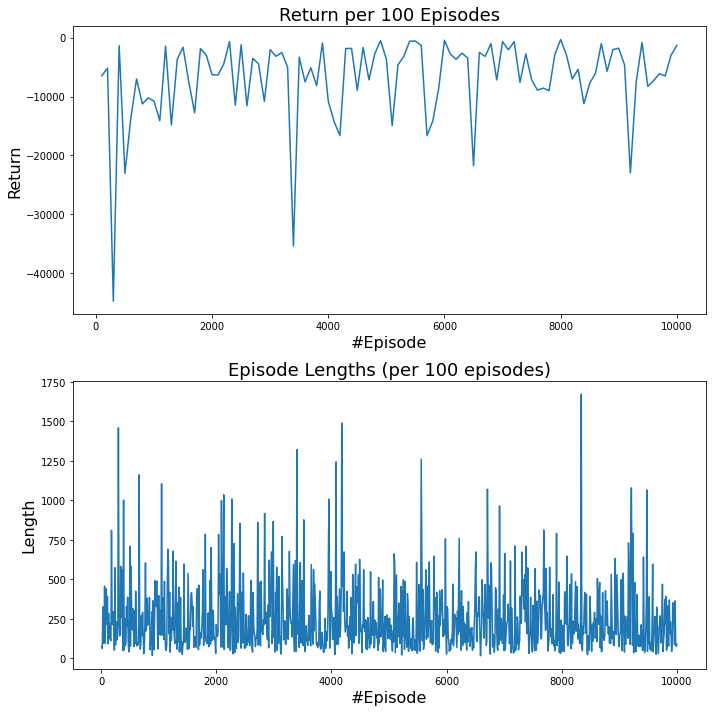

In [ ]:
V, stats = policyEvaluation(initPolicy, stats=True)
print()
plotStateValues(V)
print()
print('\nState Values for initial policy:\n')
print(np.round(V,2),'\n')
displayStats(stats)

# Task 2

Starting from the initial policy, choose actions using ε-greedy action selection (ε=0.1)

Improve the policy for 1000 episodes.

Compute the resulting state value V(s) for each grid cell.

Visualize the resulting policy using arrows.

## SARSA, Epsilon Greedy Policy, Non-Deterministic Actions

100%|██████████| 10000/10000 [00:07<00:00, 1279.80it/s]


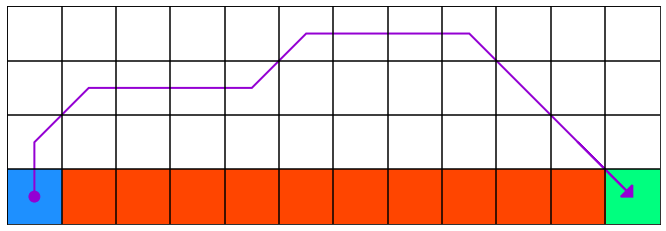

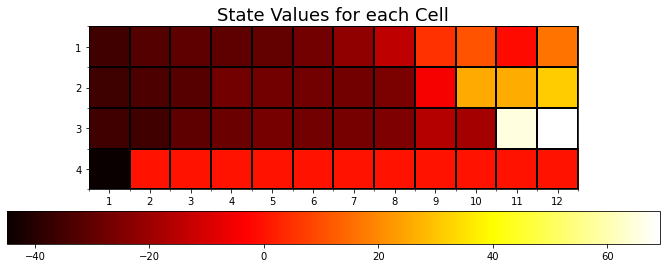


State Values for learned policy:

[[-35.4  -32.01 -30.54 -30.18 -29.57 -26.63 -22.02 -13.76   5.15  10.95  -1.26  16.35]
 [-35.58 -33.44 -31.53 -26.85 -26.87 -26.75 -26.73 -25.56  -4.71  25.55  26.06  31.55]
 [-35.4  -35.19 -30.58 -28.17 -26.21 -26.89 -26.51 -24.95 -15.8  -18.55  65.48  69.13]
 [-44.85   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]] 



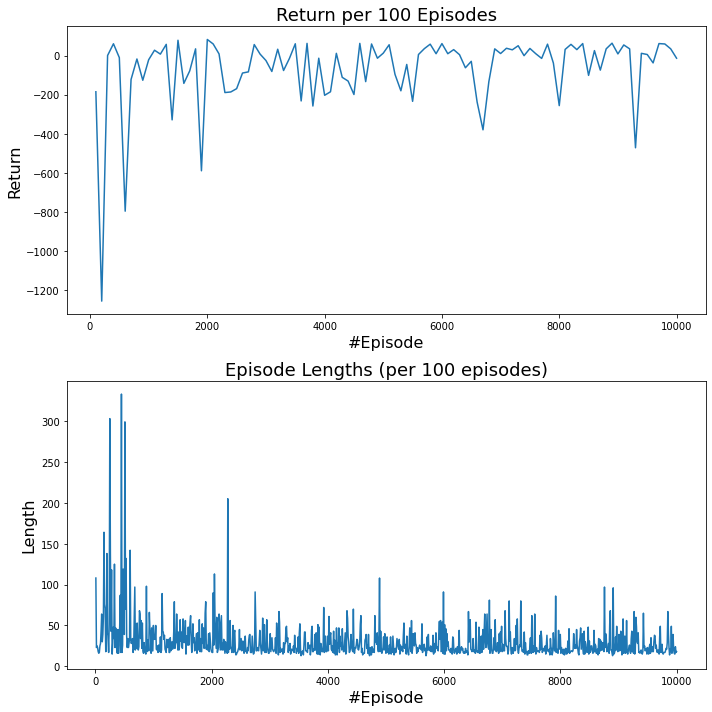

In [ ]:
Q, stats = Sarsa(deterministic=False, stats=True)
print()
plotPolicy(Q, deterministic=False)
print()
V = np.max(Q, axis=2)
plotStateValues(V)
print()
print('State Values for learned policy:\n')
print(np.round(V,2),'\n')
displayStats(stats)

## SARSA, Softmax Action Selection, Non-Deterministic Actions

100%|██████████| 10000/10000 [16:21<00:00, 10.19it/s]

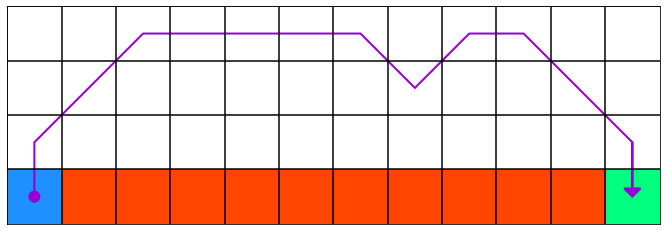

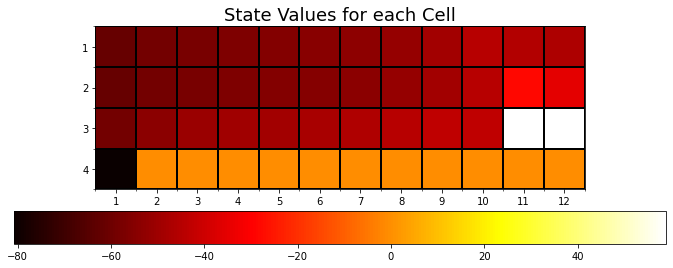


State Values for learned policy:

[[-61.36 -58.93 -57.61 -56.58 -55.52 -54.51 -53.41 -51.57 -48.7  -44.72 -45.42 -46.57]
 [-61.42 -58.79 -57.41 -56.44 -55.41 -54.62 -53.53 -51.59 -49.07 -44.36 -28.12 -35.4 ]
 [-58.67 -53.75 -50.55 -49.42 -48.61 -47.59 -46.15 -44.45 -42.67 -42.74  58.69  59.  ]
 [-80.79   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]] 



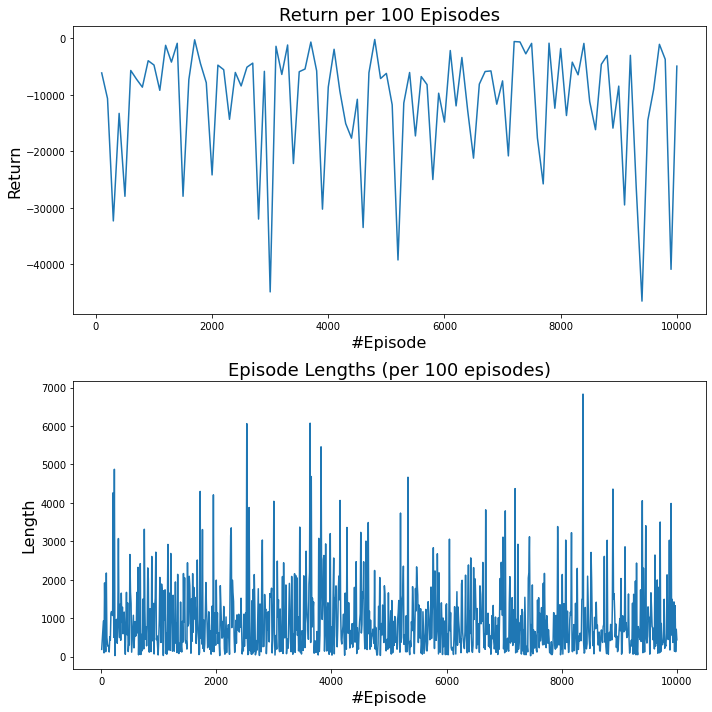

In [ ]:
Q, stats = Sarsa(softmax=True, deterministic=False, stats=True)
print()
plotPolicy(Q, deterministic=False)
print()
V = np.max(Q, axis=2)
plotStateValues(V)
print()
print('State Values for learned policy:\n')
print(np.round(V,2),'\n')
displayStats(stats)

## Q-Learning, Epsilon Greedy Policy, Non-Deterministic Actions

100%|██████████| 10000/10000 [00:06<00:00, 1630.25it/s]


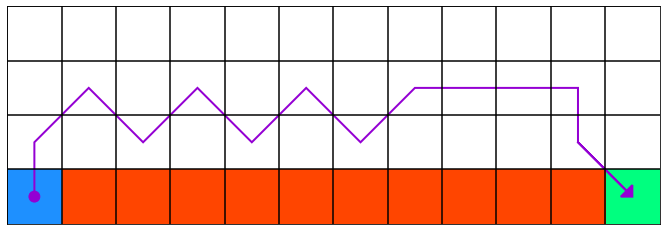

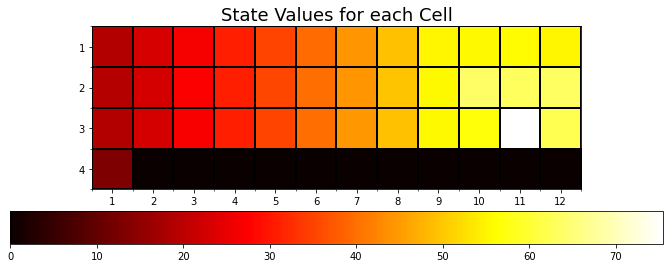


State Values for learned policy:

[[18.93 23.07 26.74 31.06 35.24 39.5  44.28 49.25 55.36 55.57 55.93 55.13]
 [19.15 22.86 27.22 31.04 35.57 39.79 44.41 49.72 55.45 63.82 63.11 63.56]
 [18.97 22.95 26.89 31.1  35.31 39.78 44.5  49.42 55.45 57.14 75.42 62.35]
 [13.15  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]] 



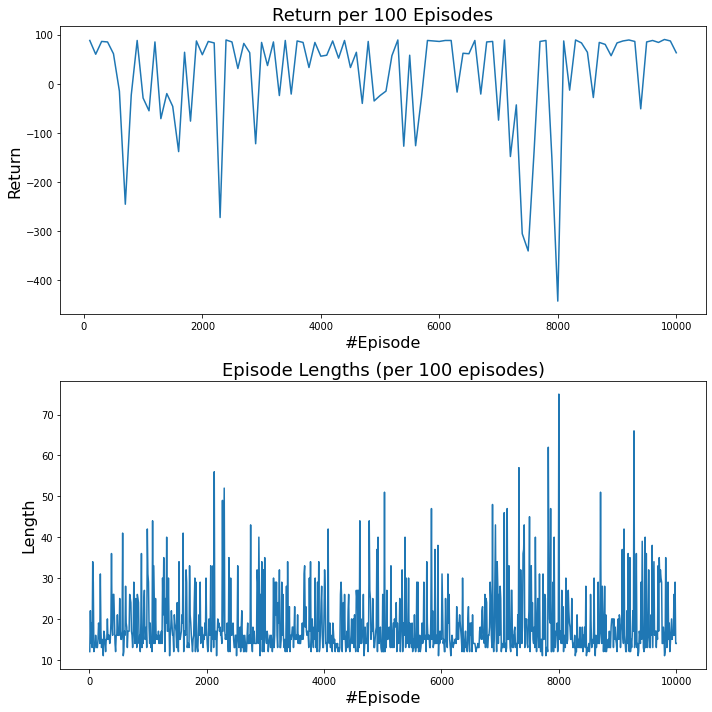

In [ ]:
Q, stats = QLearn(deterministic=False, stats=True)
print()
plotPolicy(Q, deterministic=False)
print()
V = np.max(Q, axis=2)
plotStateValues(V)
print()
print('State Values for learned policy:\n')
print(np.round(V,2),'\n')
displayStats(stats)

## Q-Learning, Softmax Action Selection, Non-Deterministic Actions

100%|██████████| 10000/10000 [03:55<00:00, 42.41it/s]


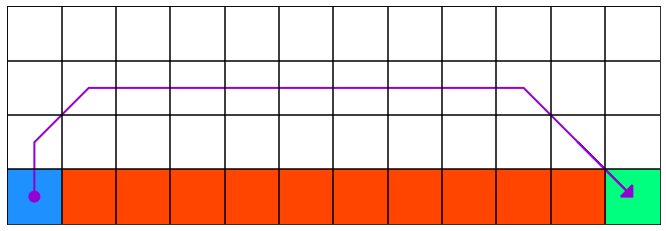

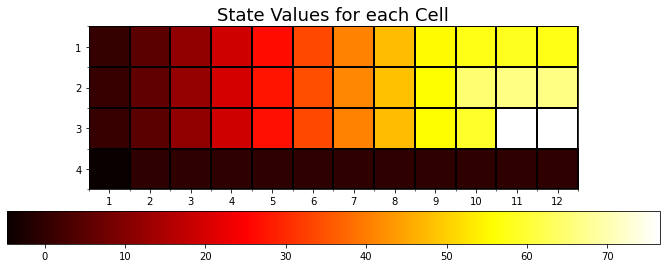


State Values for learned policy:

[[ 0.7   5.4  11.83 19.39 26.72 33.92 40.75 47.82 55.45 57.55 58.3  57.68]
 [ 1.03  5.9  12.4  19.97 27.47 34.49 41.37 48.45 55.82 64.85 66.49 66.45]
 [ 0.79  5.48 11.83 19.34 26.79 33.88 40.78 47.8  55.64 59.29 76.47 76.49]
 [-4.65  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]] 



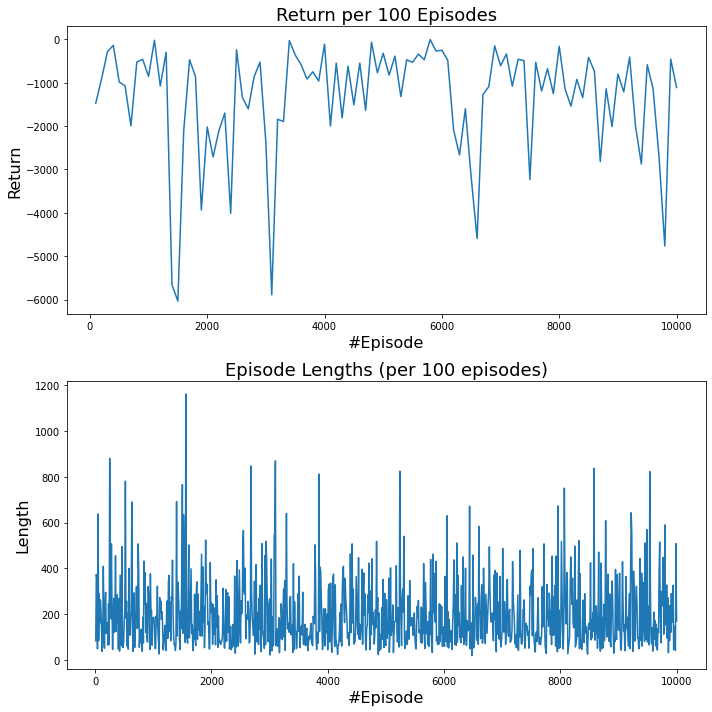

In [ ]:
Q, stats = QLearn(softmax=True, deterministic=False, stats=True)
print()
plotPolicy(Q, deterministic=False)
print()
V = np.max(Q, axis=2)
plotStateValues(V)
print()
print('State Values for learned policy:\n')
print(np.round(V,2),'\n')
displayStats(stats)

## Double Q-Learning, Epsilon Greedy Policy, Non-Deterministic Actions

100%|██████████| 10000/10000 [00:06<00:00, 1493.47it/s]


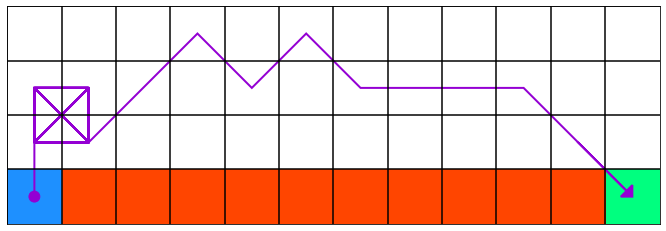

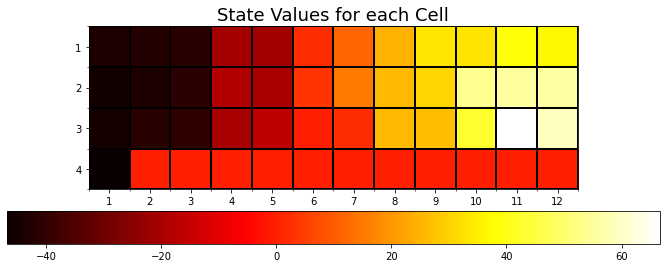


State Values for learned policy:

[[-43.25 -42.31 -41.58 -20.26 -21.12   2.    12.13  24.88  33.59  33.05  38.34  36.77]
 [-45.   -43.51 -40.67 -18.19 -19.37   3.54  15.26  26.01  30.73  54.07  55.75  56.  ]
 [-44.53 -41.82 -40.38 -19.86 -16.62  -0.15   2.26  26.27  27.04  42.99  66.59  59.12]
 [-46.74   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]] 



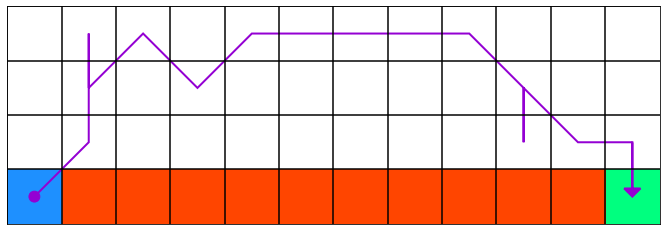

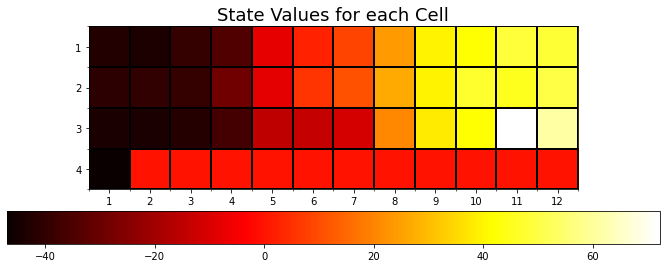


State Values for learned policy:

[[-42.44 -43.56 -39.17 -34.02  -7.77   2.53   8.69  24.14  40.01  41.96  48.47  48.04]
 [-40.6  -39.77 -39.16 -28.55  -8.19   5.83  11.11  26.75  40.    47.07  45.56  50.24]
 [-43.96 -44.04 -42.07 -36.67 -14.84 -13.69 -10.69  20.98  38.36  42.06  72.19  61.29]
 [-46.96   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]] 



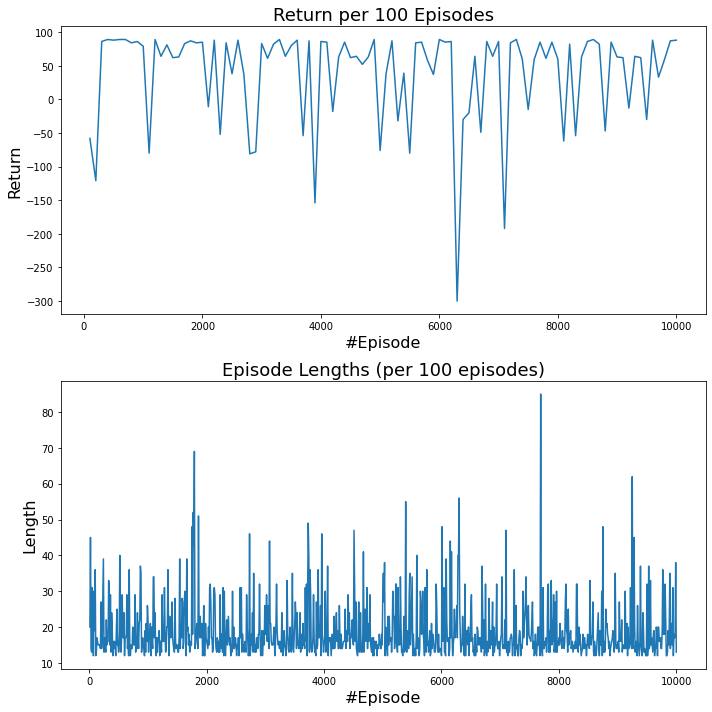

In [ ]:
Q1, Q2, stats = DoubleQLearn(deterministic=False, stats=True)
print()
plotPolicy(Q1, deterministic=False)
print()
V1 = np.max(Q1, axis=2)
plotStateValues(V1)
print()
print('State Values for learned policy:\n')
print(np.round(V1,2),'\n')
plotPolicy(Q2, deterministic=False)
print()
V2 = np.max(Q2, axis=2)
plotStateValues(V2)
print()
print('State Values for learned policy:\n')
print(np.round(V2,2),'\n')
displayStats(stats)

## Double Q-Learnig, Softmax Action Selection, Non-Deterministic Actions

100%|██████████| 10000/10000 [01:14<00:00, 134.36it/s]


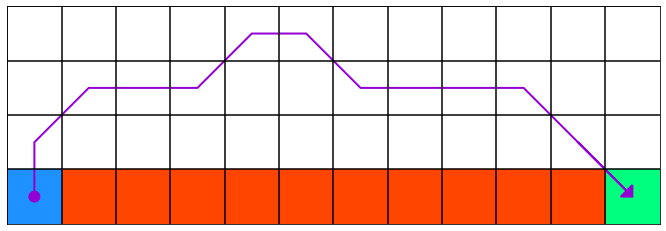

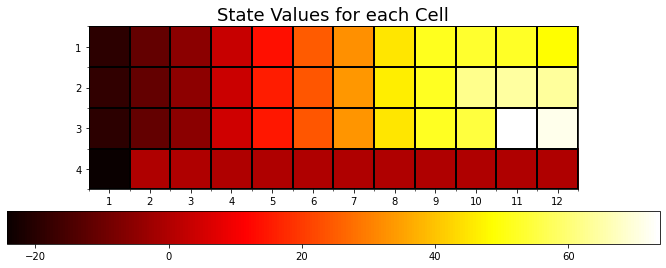


State Values for learned policy:

[[-19.02 -10.95  -5.14   3.59  13.99  25.04  32.51  45.27  51.54  53.39  52.4   48.8 ]
 [-18.34 -10.85  -4.92   3.85  15.6   23.97  33.6   46.42  52.07  62.29  64.2   63.9 ]
 [-18.93 -10.85  -5.49   4.58  14.83  24.07  33.42  45.23  51.97  54.79  73.7   71.57]
 [-24.24   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]] 



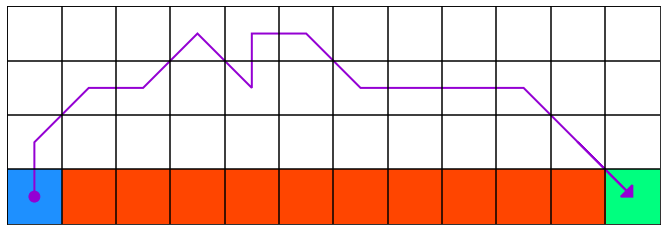

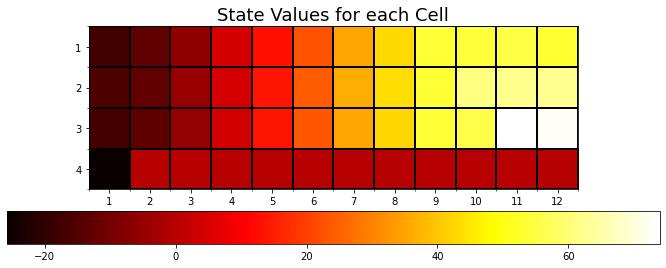


State Values for learned policy:

[[-17.38 -12.68  -5.66   4.25  12.88  22.99  35.22  42.86  53.9   54.42  55.57  53.39]
 [-15.95 -12.57  -4.61   4.48  13.74  24.43  36.33  43.58  53.82  61.29  62.44  63.01]
 [-16.93 -12.92  -5.06   4.03  13.24  23.53  35.04  42.58  54.05  55.74  73.96  72.91]
 [-25.76   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.  ]] 



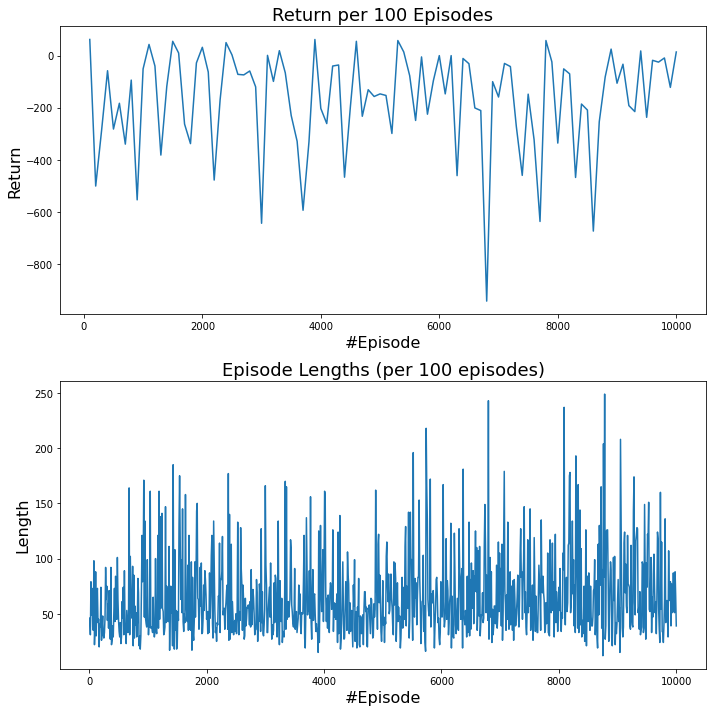

In [ ]:
Q1, Q2, stats = DoubleQLearn(softmax=True, deterministic=False, stats=True)
print()
plotPolicy(Q1, deterministic=False)
print()
V1 = np.max(Q1, axis=2)
plotStateValues(V1)
print()
print('State Values for learned policy:\n')
print(np.round(V1,2),'\n')
plotPolicy(Q2, deterministic=False)
print()
V2 = np.max(Q2, axis=2)
plotStateValues(V2)
print()
print('State Values for learned policy:\n')
print(np.round(V2,2),'\n')
displayStats(stats)